# Spatial Clustering of Sentinel-2 Image Data of Lake Neusiedl
----
This notebook applies spatial clustering algorithms to raster images from Sentinel-2 of Lake Neusiedl. The goal is to identify classes (clusters) of the reed belt of the lake, based on the polygon covering the entire reed belt.

In [1]:
import glob
import os
import rasterio
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask

## Getting the Data
---
The data is split into two tiles, each of which contains one image per band and time step of the observation. The individual tiles are first merged on the basis of merging each corresponding pair of band-timestamp images. The procedure for merging tiles is available in the `merge_tiles.py` accompanying script. The variable `merged_path` now points to the directory where the results of the tile merging are stored.

In [2]:
merged_path = r"/home/e12331438/merged/"
files_merged = glob.glob(os.path.join(merged_path, "*"))

In [3]:
files_merged = list(filter(lambda file_name: "B06" not in file_name, files_merged))

In [4]:
len(files_merged)

80

In [5]:
files_merged[0]

'/home/e12331438/merged/20190421_B02.tif'

## Data Preprocessing 

### Shapefile with Reed Belt Polygon
-----
In this section the shapefile containing the reed belt polygon is loaded and applied to the bands as to obtain only those parts of the data which belong to the reed to prepare it for clustering.

In [6]:
import geopandas as gpd

polygons = gpd.read_file("/home/e12331438/shared/datasets/rs/students/e12331438/shapefiles/reed_belt.shp")
polygons.head()

,id,@id,area,FID,geometry
0,relation/409669,relation/409669,164182545,0,"MULTIPOLYGON (((16.77260 47.69530, 16.77260 47..."
1,relation/2251752,relation/2251752,4485,1,"POLYGON ((12.33274 47.65119, 12.33320 47.65114..."
2,relation/3010768,relation/3010768,308419,2,"POLYGON ((13.90993 46.57033, 13.90952 46.57021..."
3,relation/3168674,relation/3168674,7538,3,"POLYGON ((13.33830 47.57837, 13.33838 47.57845..."
4,relation/3625694,relation/3625694,1706102,4,"POLYGON ((16.78315 47.77325, 16.78311 47.77312..."


In [7]:
polygons.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Matching Coordinates
----
It is important to ensure that the sampling points as well as the raster images are in the same geoprojection before the sampling of the points from the raster images occurs.

In [8]:
with rasterio.open(files_merged[0]) as src:
    raster_crs = src.crs

In [9]:
raster_crs

CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [10]:
polygons_projected = polygons.to_crs(raster_crs)
polygons_projected

,id,@id,area,FID,geometry
0,relation/409669,relation/409669,164182545,0,"MULTIPOLYGON (((5294854.983 1558066.009, 52948..."
1,relation/2251752,relation/2251752,4485,1,"POLYGON ((4963097.345 1596095.942, 4963130.881..."
2,relation/3010768,relation/3010768,308419,2,"POLYGON ((5064472.405 1459226.424, 5064439.411..."
3,relation/3168674,relation/3168674,7538,3,"POLYGON ((5036751.714 1576580.914, 5036758.820..."
4,relation/3625694,relation/3625694,1706102,4,"POLYGON ((5296475.329 1566623.960, 5296470.798..."
...,...,...,...,...,...
754,way/1149513542,way/1149513542,1862,770,"POLYGON ((5279949.194 1615786.477, 5279961.041..."
755,way/1149513543,way/1149513543,2922,771,"POLYGON ((5280036.408 1615742.184, 5280023.231..."
756,way/1153260927,way/1153260927,6860,772,"POLYGON ((5245648.647 1593978.757, 5245644.022..."
757,way/1153505722,way/1153505722,57,773,"POLYGON ((5190816.167 1499499.448, 5190817.549..."


The first entry contains the polygon of the reed belt of Lake Neusiedl.

In [11]:
reed_belt = polygons_projected.geometry[0]

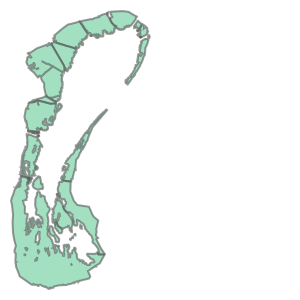

In [12]:
reed_belt

The following code snippet can be used to create a true-color composite example of the reed belt from 2019 to look at the data using QGIS Desktop for example.

In [13]:
year = "20190809"
for f in ["B02", "B03", "B04"]:
    # try:
    f_name = f"./merged/{year}_{f}.tif"
    with rasterio.open(f_name) as src:
        arr, out = mask(src, [reed_belt], crop=True)
        meta_c = src.meta.copy()
        meta_c.update({
            "height": arr.shape[1],
            "width": arr.shape[2],
            "transform": out
        })
    out_path = f"{year}_{f}_belt_crop.tif"   
    with rasterio.open(out_path, "w", **meta_c) as dest:
        dest.write(arr)

#### Masking the Images
----
Once the data from the images as well as the points are in the same geoprojections, the masking of the rasters with the polygon mask is performed. The images are cropped to only contain the area of interest, and values outside the mask are filled with the `nodata` value.
The clustering will be performed at the (approximately) same time-step per every year.

In [14]:
timesteps = ["20190809", "20200721", "20210616", "20220721"]

In [15]:
from rasterio.mask import mask
def mask_band(band_path:str, shapes):
    """
    Masks the raster with the given polygons. Also crops the result to 
    only contain the area of interest.

    Args:
        band_path (str): Path to the raster image with the band values.
        shapes (List[polygon]): List of polygons to mask with. 

    Returns:
        List[int]: The maksed raster.
    """
    with rasterio.open(band_path) as src:
        arr, _ = mask(src, shapes, crop=True)
        arr.reshape((arr.shape[1], arr.shape[2], 1))
        return arr

To ensure proper calculation of the indices, the values are scaled to range [0, 1] by dividing the `nodata` maximal value in the rasters.

In [16]:
masked_bands = {}

for t_step in timesteps:
    masked_bands[t_step] = {}
    for band_name in ["B02", "B04", "B08", "B11"]:
        band= mask_band(merged_path + f"{t_step}_{band_name}.tif", [reed_belt]).astype(np.float64) / 65535.0
        masked_bands[t_step][band_name] = band

### Retrieving Indices
---
As a final step, the raw band values are used as inputs to retrieve indices. The indices will be used instead of the raw values of the bands as inputs to the clustering algorithms. The formulas for each of the indices are implemented in `index_calculation.py` script.

In [17]:
from index_calculation import ndmi, ndvi, evi

In [18]:
ndmi_per_year = {}
ndvi_per_year = {}
evi_per_year = {}

In [19]:
for t_step in timesteps:
    band02 = masked_bands[t_step]["B02"]
    band04 = masked_bands[t_step]["B04"]
    band08 = masked_bands[t_step]["B08"]
    band11 = masked_bands[t_step]["B11"]
    
    assert band08.shape == band11.shape
    ndmi_per_year[t_step] = ndmi(band08, band11)

    assert band08.shape == band04.shape
    ndvi_per_year[t_step] = ndvi(band08, band04)
    
    assert band04.shape == band02.shape
    evi_per_year[t_step] = evi(band08, band04, band02)

## Spatial Clustering
---
Finally, the clustering is performed for each of the three extracted indices each with 4 different rasters observed at the (approximately) same timestep per each observed year 2019-2022. Multiple clustering algorithms are applied to compare the obtained results across them. 

In [20]:
from sklearn.metrics import silhouette_score


# collect performance metrics from all model configurations
metrics = {
    "index": [],
    "n_clusters": [],
    "inertia": [],
    "silhouette_score": []
}

def save_metrics(index_name, model, X, y):
    """
    Calculate the performance metrics of the model
    and store them to the dictionary.
    """
    metrics["index"].append(index_name)
    metrics["n_clusters"].append(model.cluster_centers_.shape[0])
    metrics["inertia"].append(model.inertia_)
    metrics["silhouette_score"].append(silhouette_score(X, y))

In [21]:
from sklearn.utils import resample

N_SAMPLES = 100000 # number of observations for calculating silhouette score
def fit_model(model, index_name, arr, params):
    """
    Fits the model with the given parameters
    on the provided data.
    """
    arr_1D = arr.reshape((arr.shape[1]*arr.shape[2], 1)) # get each point as a single entry in 1D array
    model.set_params(**params).fit(arr_1D)
    y = model['model'].labels_

    # exclude the blank class - pixels that are not the actual reed belt
    # from calculating the metrics
    blank_label = np.argmax(np.bincount(y))
    blank_mask = y != blank_label 
    X_sample, y_sample = resample(arr_1D[blank_mask], y[blank_mask], 
                                  replace=True, n_samples=N_SAMPLES, 
                                  random_state=1111) # subsample for computational time saving
    save_metrics(index_name, model['model'], X_sample, y_sample)

    # sort the labels according to the mean values in the clusters 
    # having blank_label always first
    means = []
    for i in np.unique(y):
        if i == blank_label:
            continue
        means.append(np.mean(arr_1D[y == i]))
    sorted_means = np.argsort(means) + 1

    return y.reshape((arr.shape[1], arr.shape[2])), np.append(blank_label, sorted_means)

In [40]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib 


cmap = matplotlib.colormaps["Greens"]
colors = np.array([cmap(0), cmap(0.25), cmap(0.5), cmap(0.75), cmap(1)])

def run_model(model, index_name, yearly_values, params):
    """
    Fits the model on the data per each year and plot the 
    resulting clusters side by side.
    """
    n = len(yearly_values)
    plt.subplots(1, n, figsize=(n*6, 9))
    i = 1
    for [t_step, arr] in yearly_values.items():
        clusters, mapping = fit_model(model, index_name, arr, params)

        plt.subplot(1, n, i)
        plt.imshow(clusters, cmap=ListedColormap(colors[mapping]))
        plt.axis('off')
        plt.title(t_step)
        i += 1
    plt.tight_layout()
    plt.savefig("baz.png")
    plt.show()

### K-Means

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [24]:
kmeans = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model', KMeans(random_state=1111))])

#### NDMI

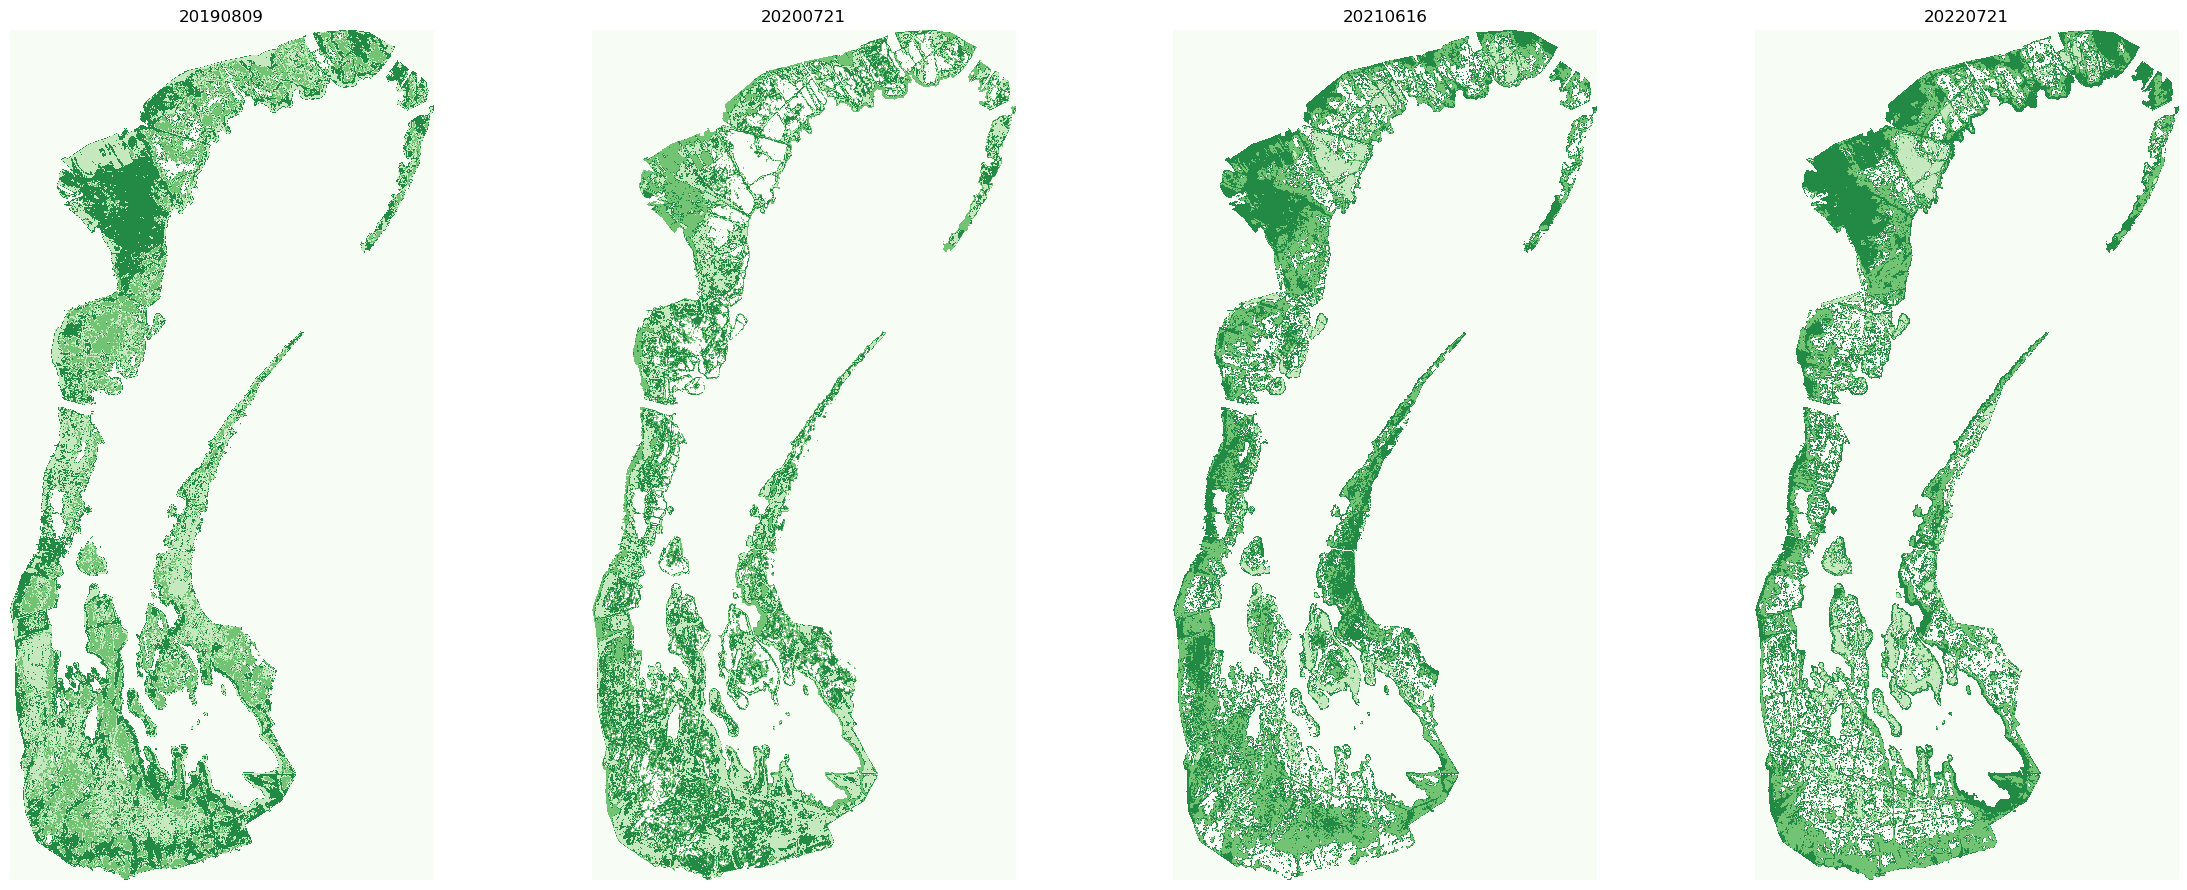

In [25]:
run_model(kmeans, "NDMI", ndmi_per_year, {"model__n_clusters": 4})

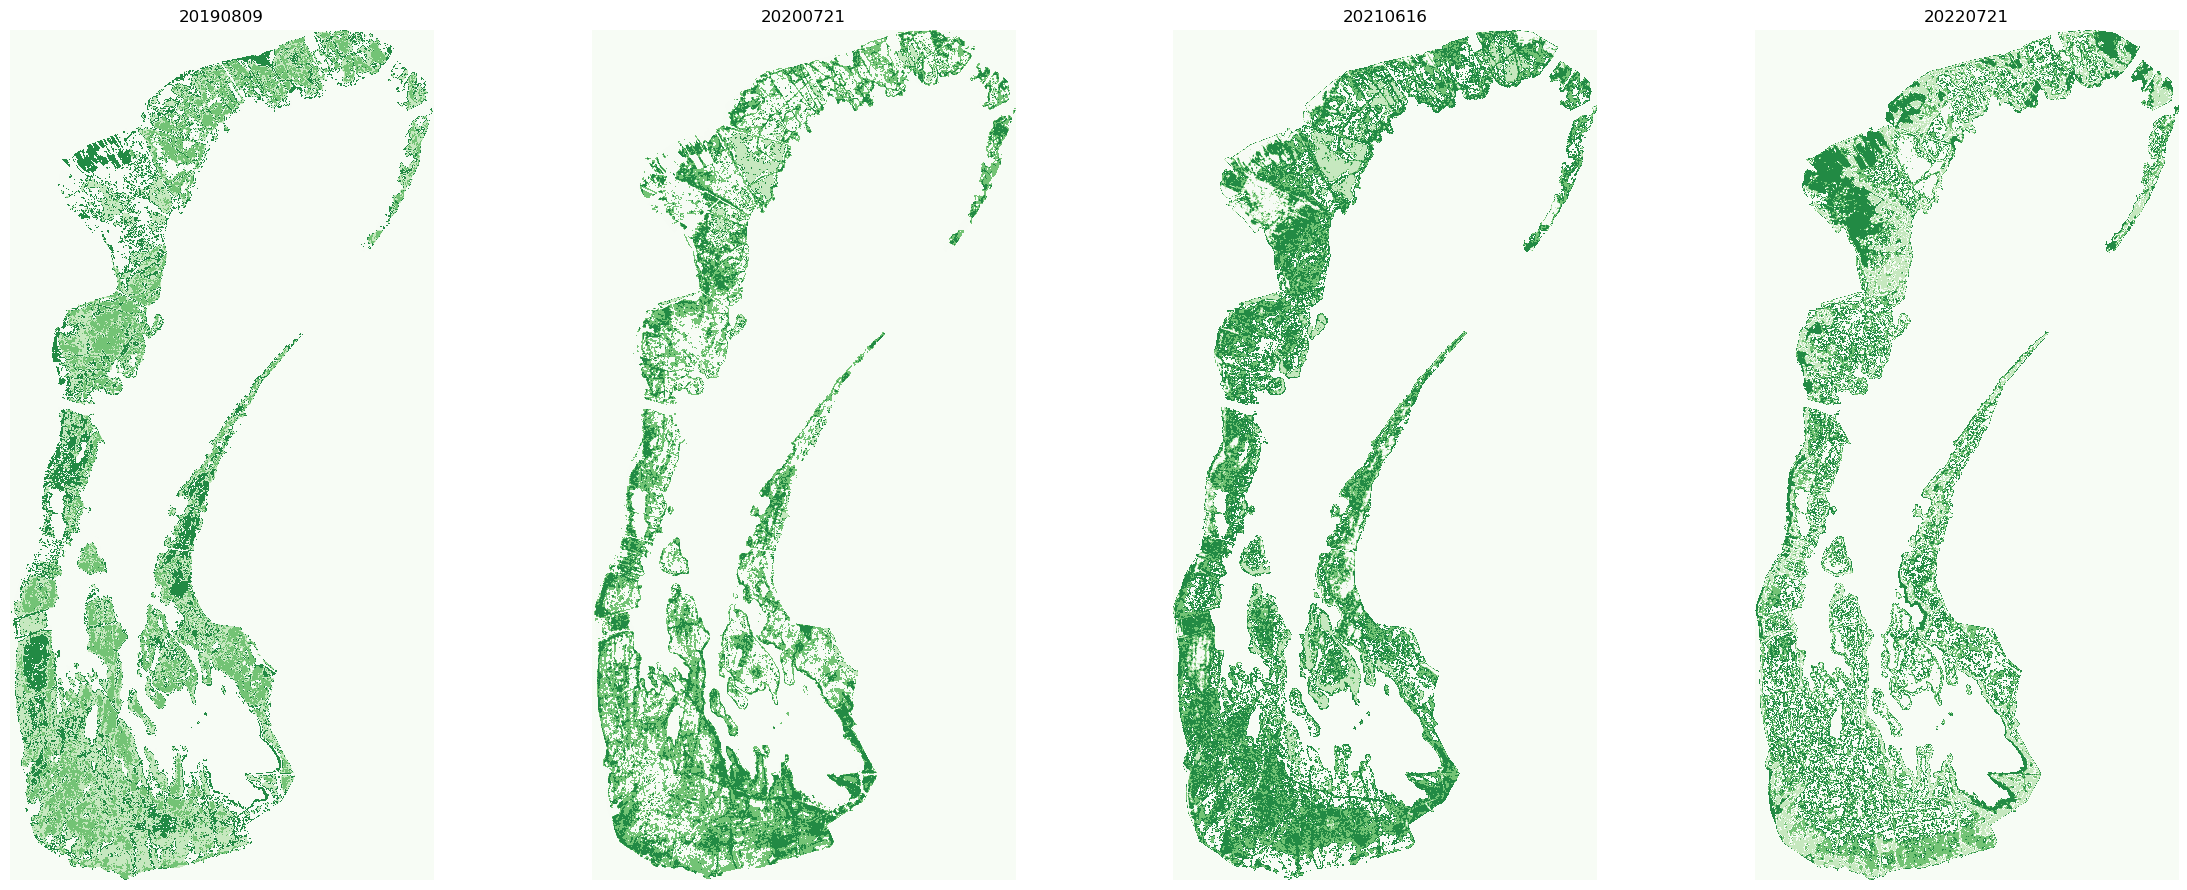

In [26]:
run_model(kmeans, "NDMI", ndmi_per_year, {"model__n_clusters": 5})

#### NDVI

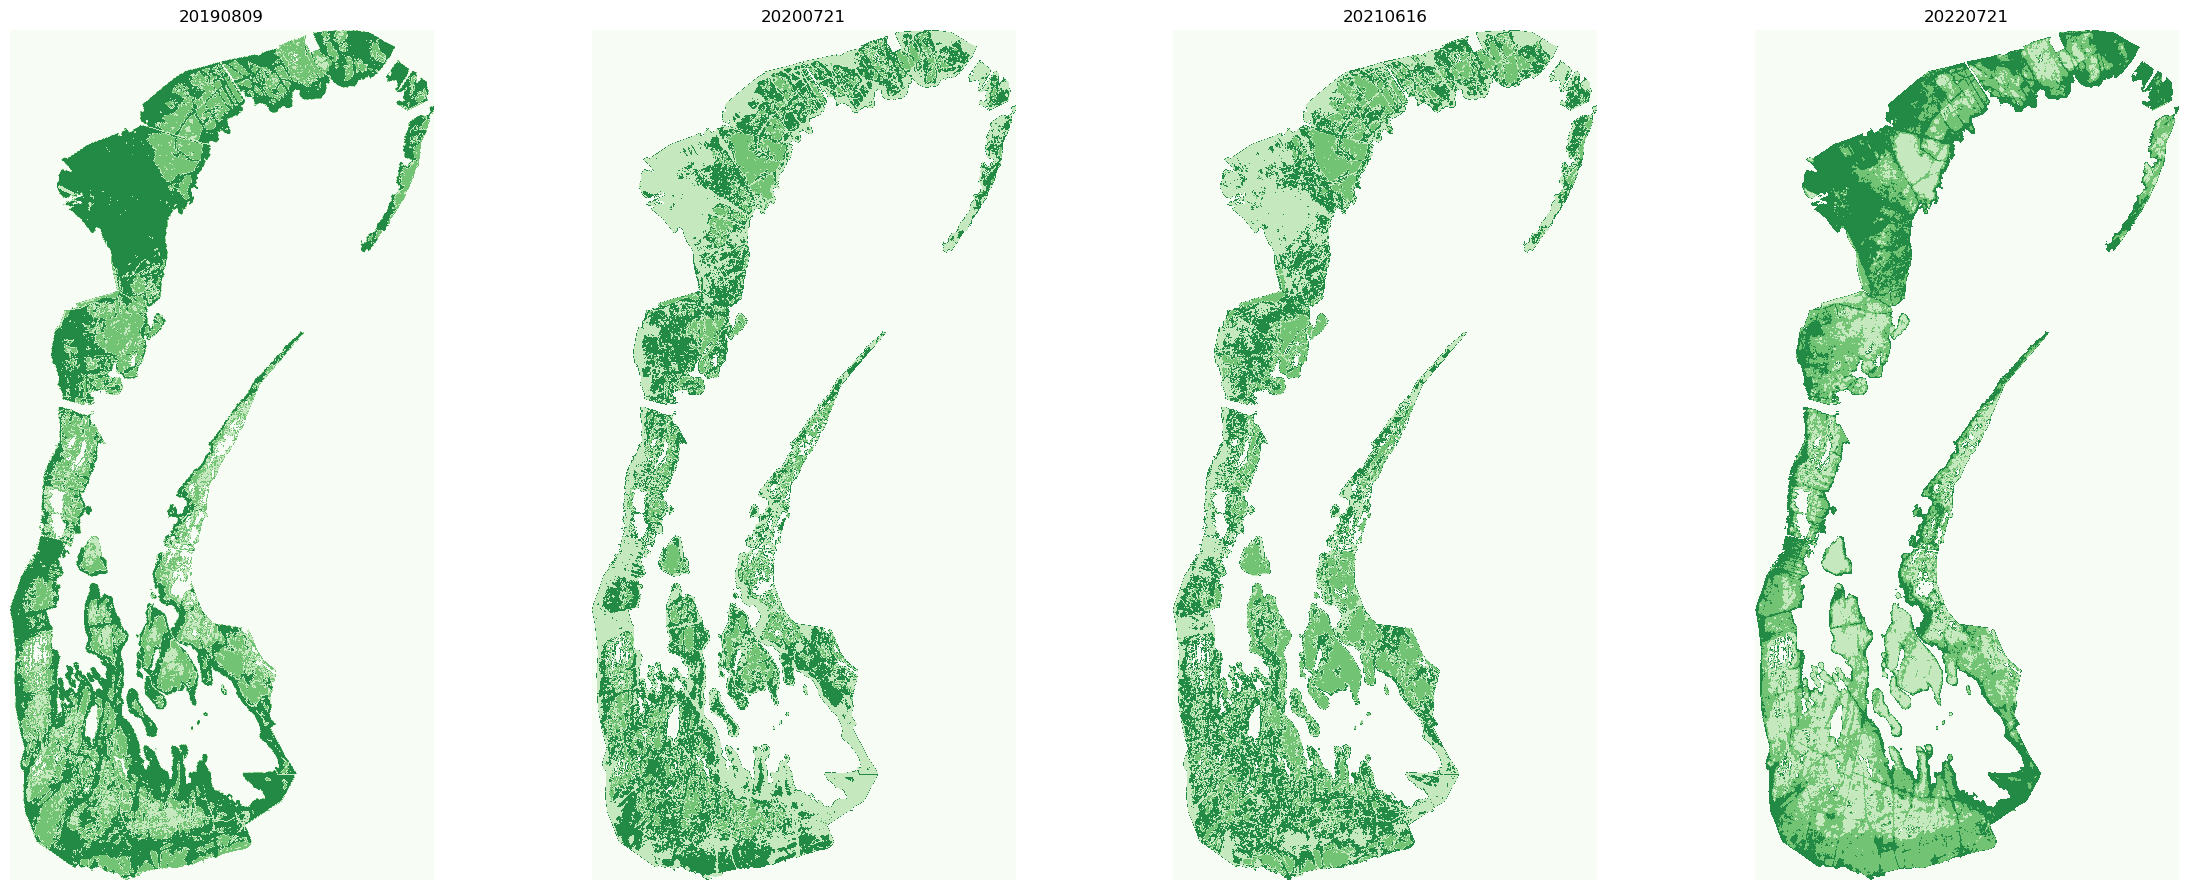

In [27]:
run_model(kmeans, "NDVI", ndvi_per_year, {"model__n_clusters": 4})

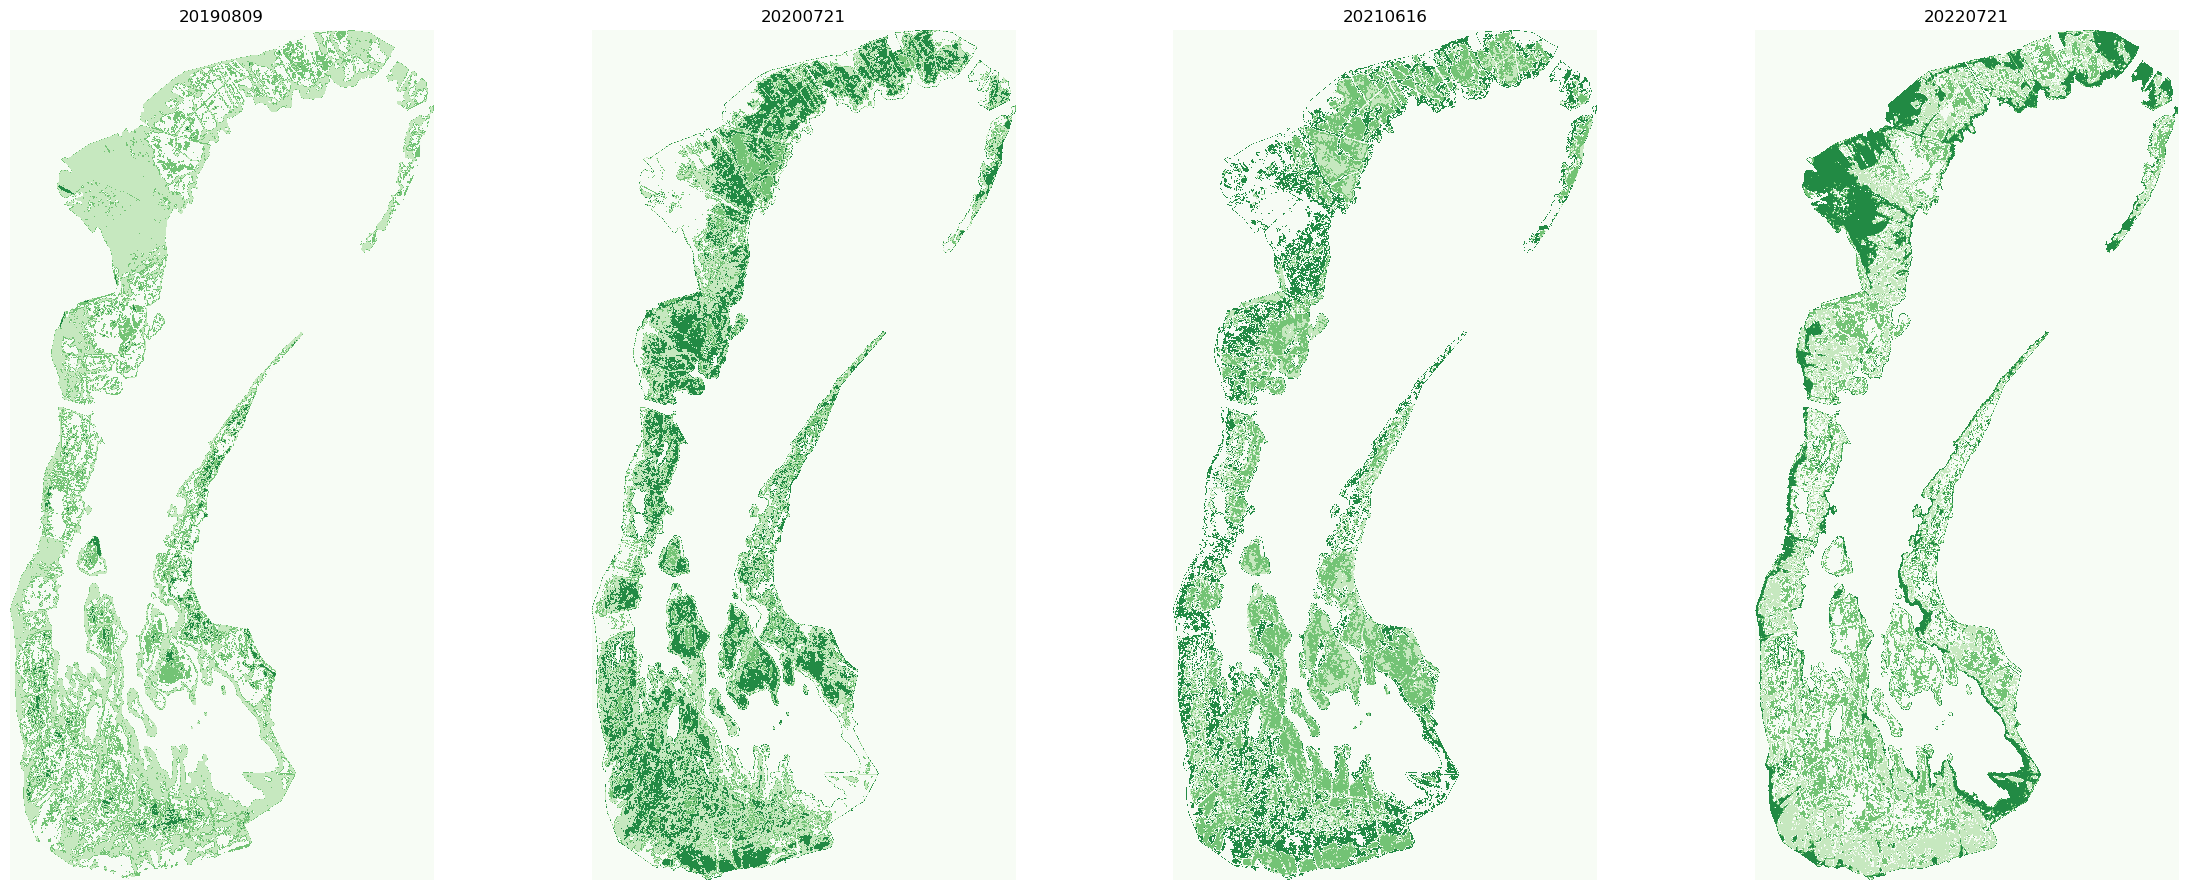

In [28]:
run_model(kmeans, "NDVI", ndvi_per_year, {"model__n_clusters": 5})

#### EVI

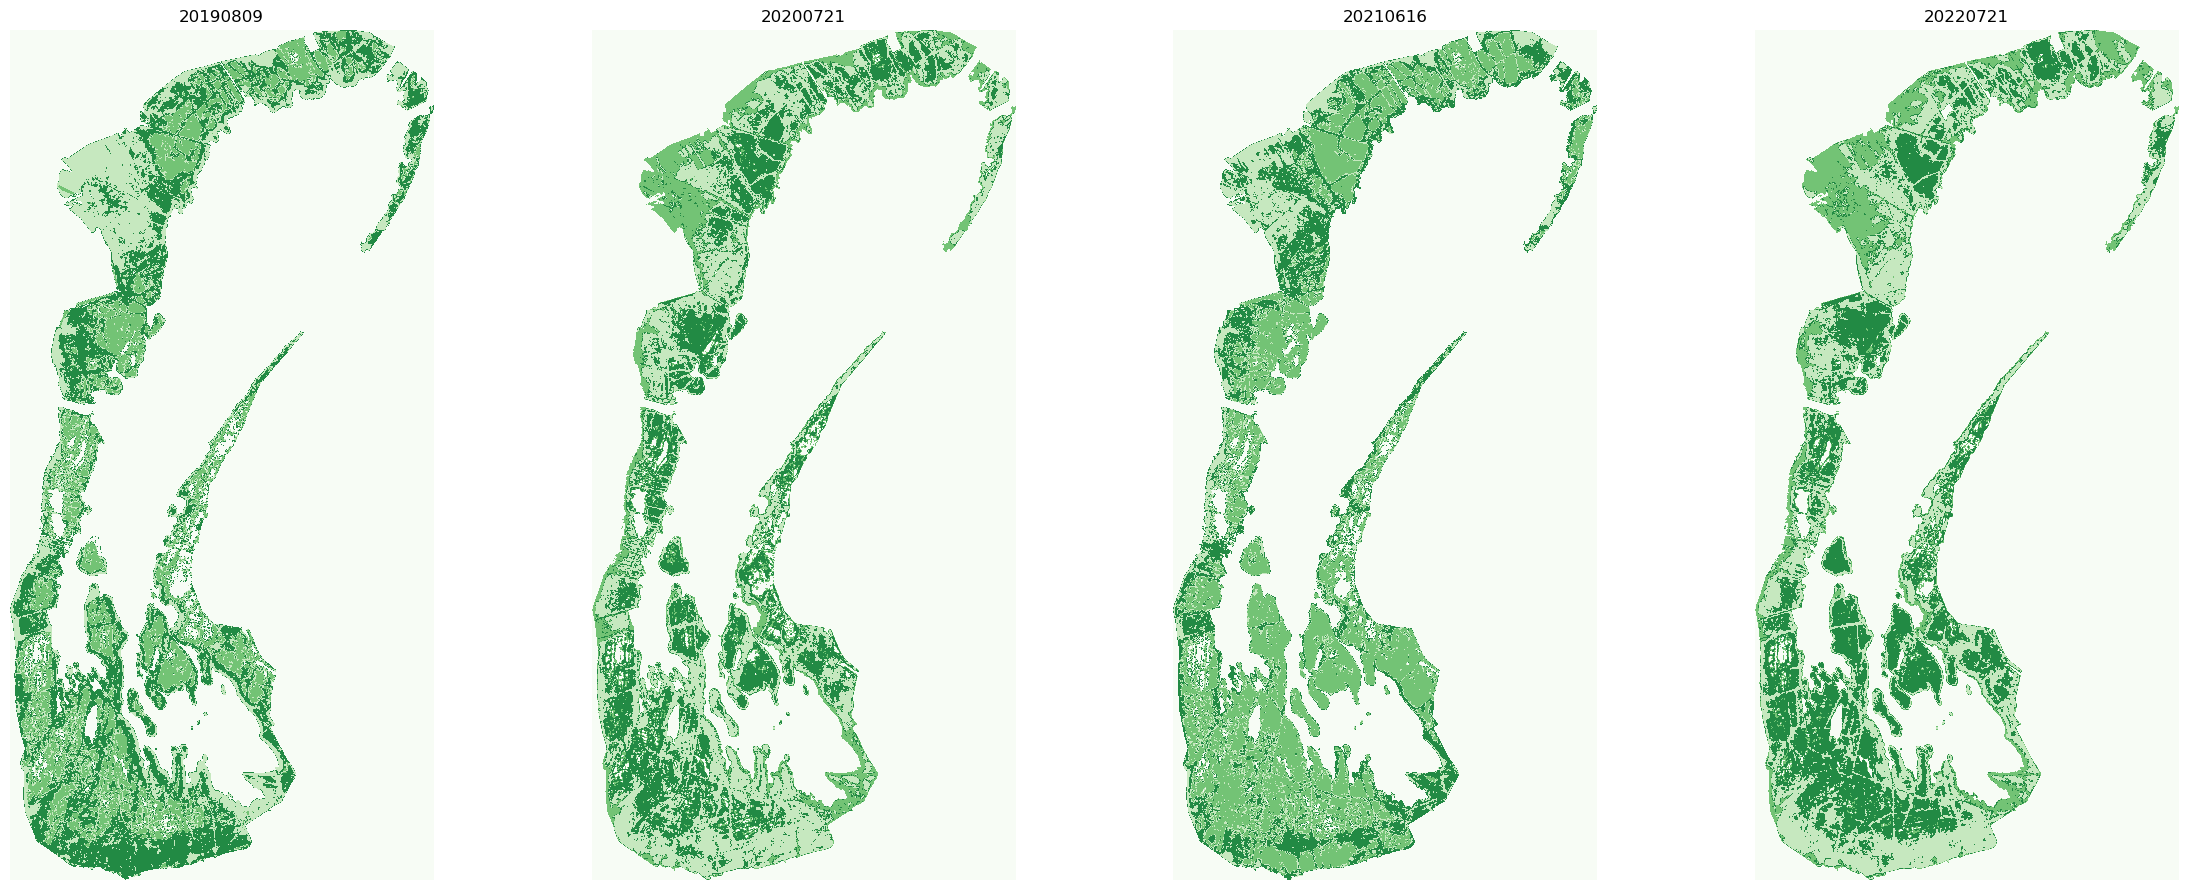

In [41]:
run_model(kmeans, "EVI", evi_per_year, {"model__n_clusters": 4})

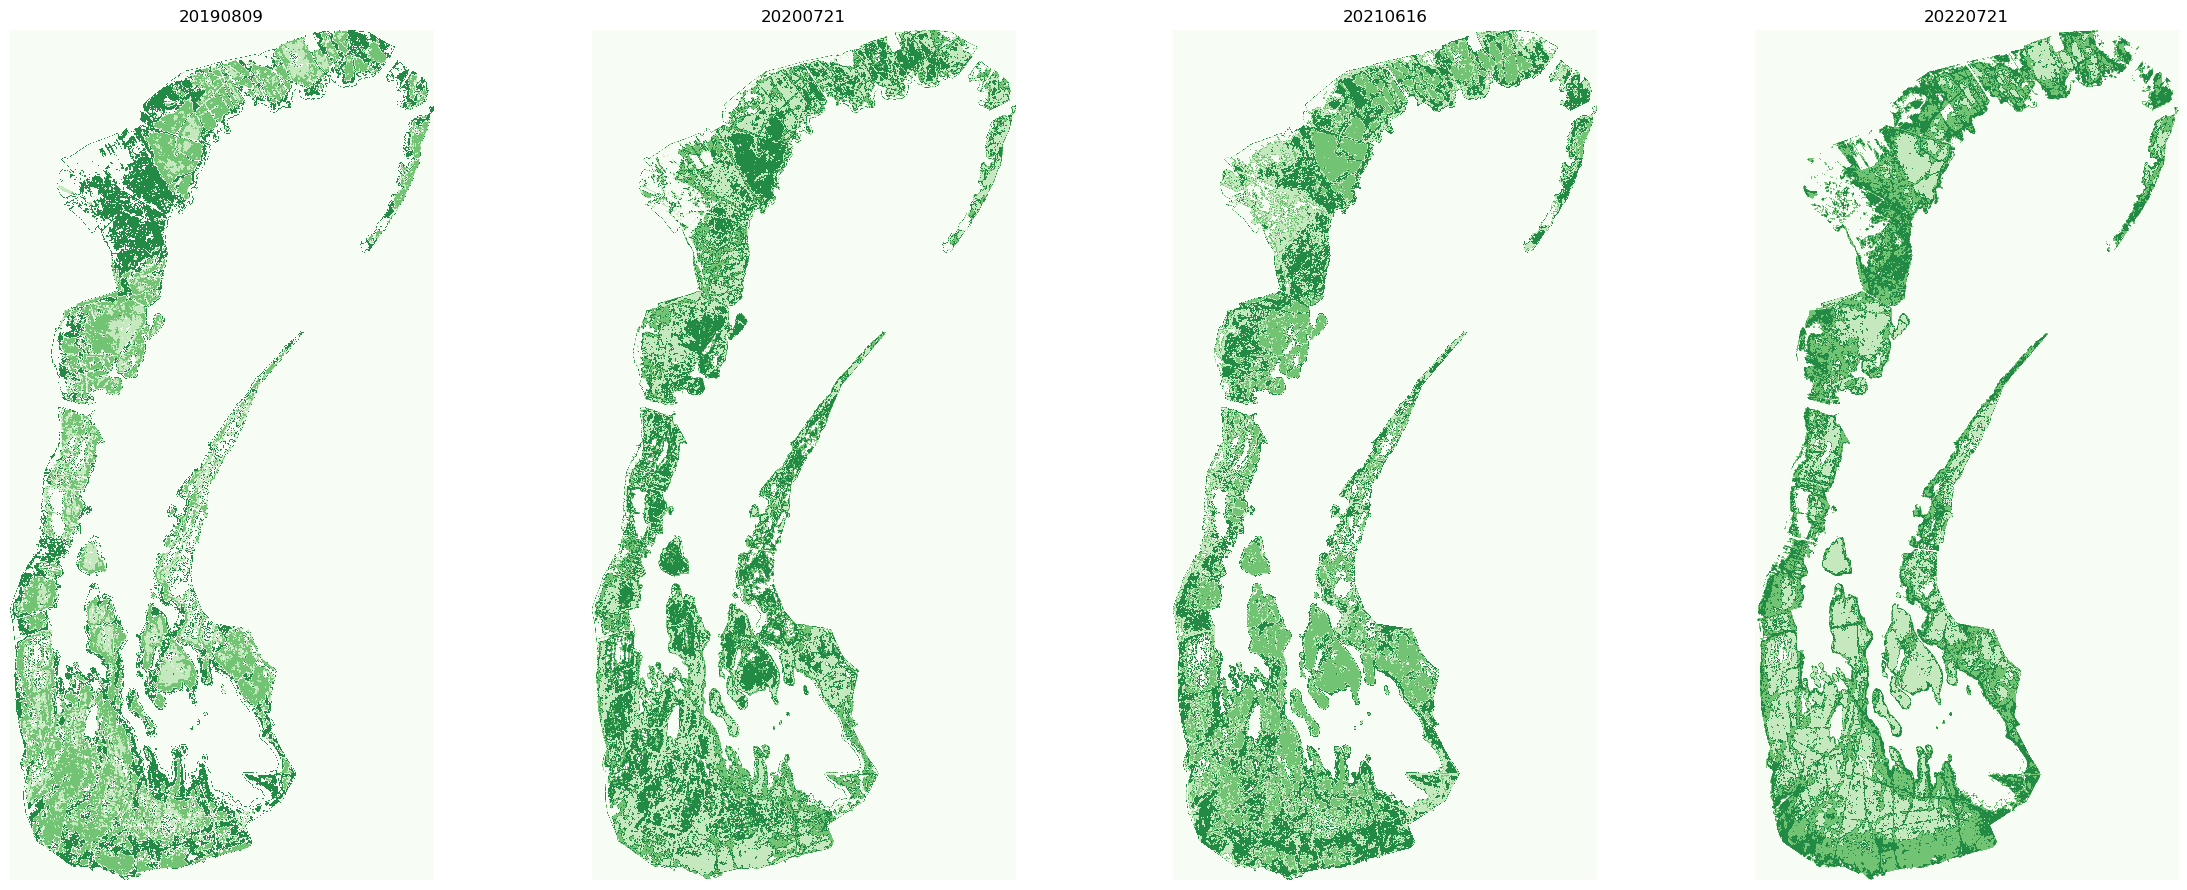

In [30]:
run_model(kmeans, "EVI", evi_per_year, {"model__n_clusters": 5})

The resulting clusters were assigned the colors based on the mean values of the points in the cluster, where the darker the green, the higher the mean. With that, the clusters with the darkest shade of green might represent the young reed as it has large values overall indicating high water content. The slightly lighter green is likely attributed to old reed, since these clusters are still covering large cohesive areas but exhibit lower values overall. The lightest (or lightest two colors depending on the number of resulting clusters) are sporadically spread out across the area, covering smaller chunks at a time, and have very low or negative values representing the broken or inundated reed. Lastly, it is important to note that the yearly development of the reed can be observed through the changes in the areas and their membership at the given clusters, like young reed eventually becoming old, or broken reed replaced by young reed.

## Results

In [34]:
pd.DataFrame(metrics).pivot(index=["index", "n_clusters"], columns=[], values=["inertia", "silhouette_score"]).groupby(["index", "n_clusters"]).mean()

inertia  silhouette_score
index n_clusters                               
EVI   4           3916.694450          0.556350
      5           2438.455605          0.539593
NDMI  4           1925.177542          0.605007
      5           1267.503027          0.586336
NDVI  4           2418.557539          0.557946
      5           1578.892179          0.541024